In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)


In [2]:
os.getcwd()

'C:\\Users\\User\\Documents\\GitHub\\Hypertension_prediction\\Hypertension(regularly sampled data)\\Codebase(previous paper codes)\\Hypertension_code_amy'

In [3]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [4]:
#!git clone https://github.com/caow13/BRITS.git

first create patient train test set

In [6]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [7]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [8]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [9]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=5)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=5)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


KNN Inputation

In [10]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

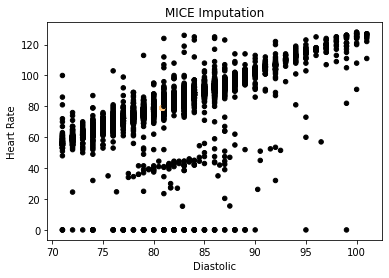

In [12]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_mice_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='MICE Imputation', colorbar=False)
#https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87#:~:text=Time%20Series%20Imputation&text=One%20way%20to%20impute%20missing,with%20the%20previously%20observed%20value

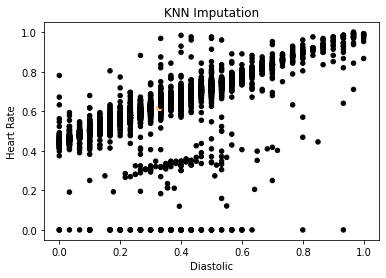

In [13]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_knn_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='KNN Imputation', colorbar=False)


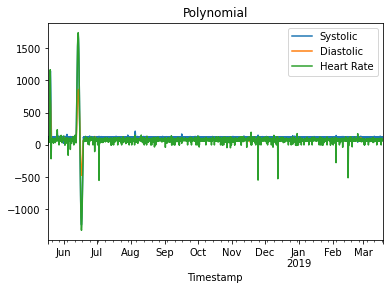

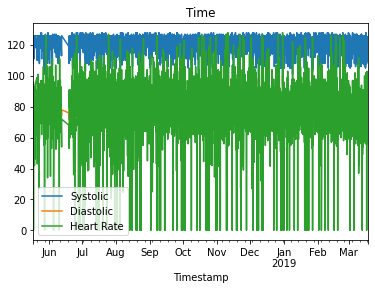

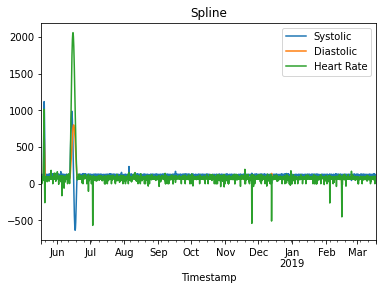

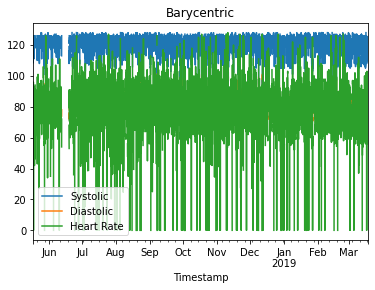

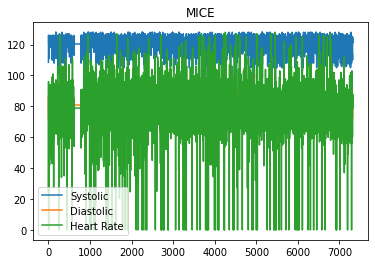

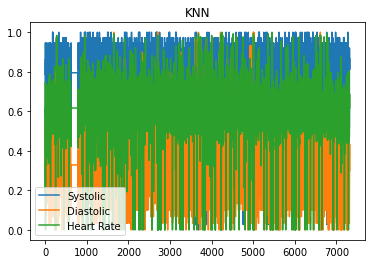

In [14]:
figsize=(40,15)
df_poly_imputed.plot(title='Polynomial')
df_time_imputed.plot(title='Time')
df_spline_imputed.plot(title='Spline')
df_barycentric_imputed.plot(title='Barycentric')
df_mice_imputed.plot(title='MICE')
df_knn_imputed.plot(title='KNN')
lines, labels = plt.gca().get_legend_handles_labels()
#labels = ['linear', 'time' ,'spline','barycentric']
plt.legend(lines, labels, loc='best')

In [15]:
!pip install adtk

In [16]:
from adtk.data import validate_series
#df_poly_imputed.index
df_time_imputed= validate_series(df_time_imputed)
print(df_time_imputed.head())

                     Systolic  Diastolic  Heart Rate
Timestamp                                           
2018-05-17 10:00:00     108.5       72.0        24.5
2018-05-17 11:00:00     119.0       76.0        53.0
2018-05-17 12:00:00     123.0       81.0        82.0
2018-05-17 13:00:00     126.0       87.0        96.0
2018-05-17 14:00:00     121.5       80.0        40.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

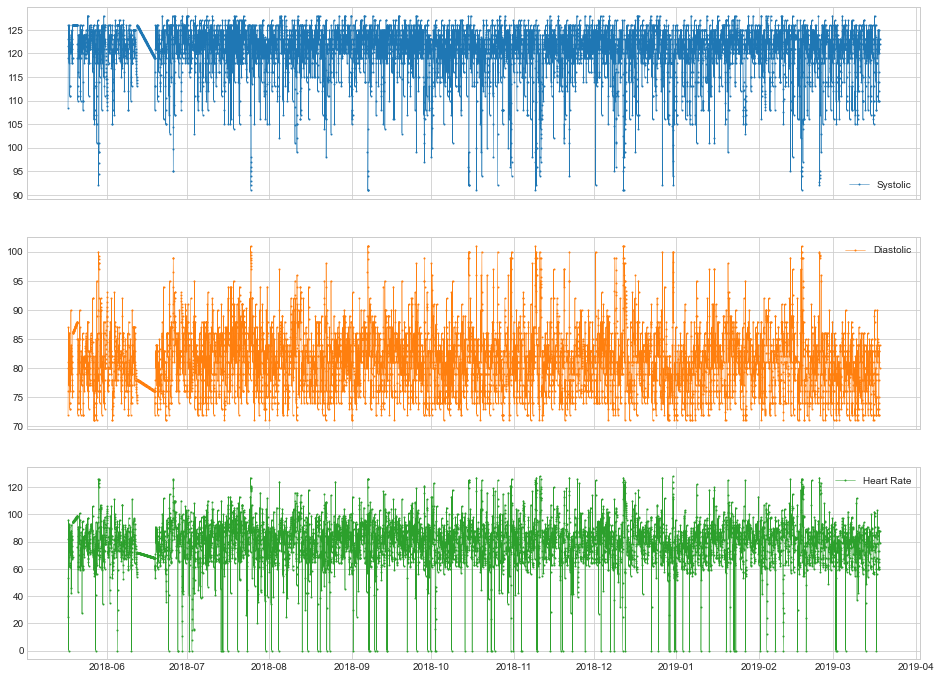

In [17]:
from adtk.visualization import plot
plot(df_time_imputed)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

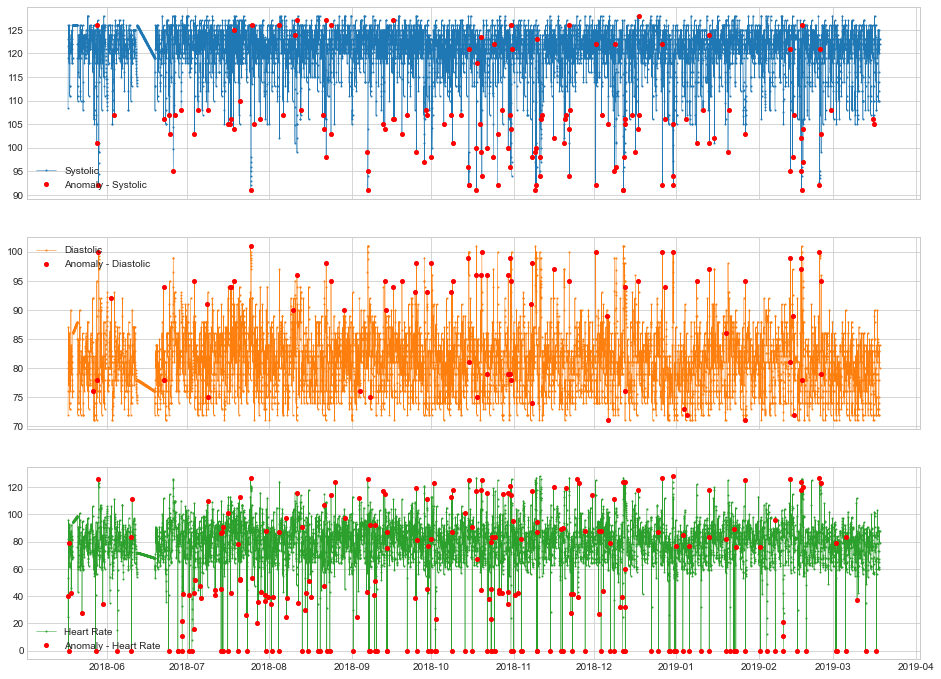

In [18]:
from adtk.detector import *
autoregression_ad = AutoregressionAD()
anomalies = autoregression_ad.fit_detect(df_time_imputed)
parameter = autoregression_ad.get_params()

plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [19]:
parameter

{'n_steps': 1,
 'step_size': 1,
 'regressor': LinearRegression(),
 'c': 3.0,
 'side': 'both'}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

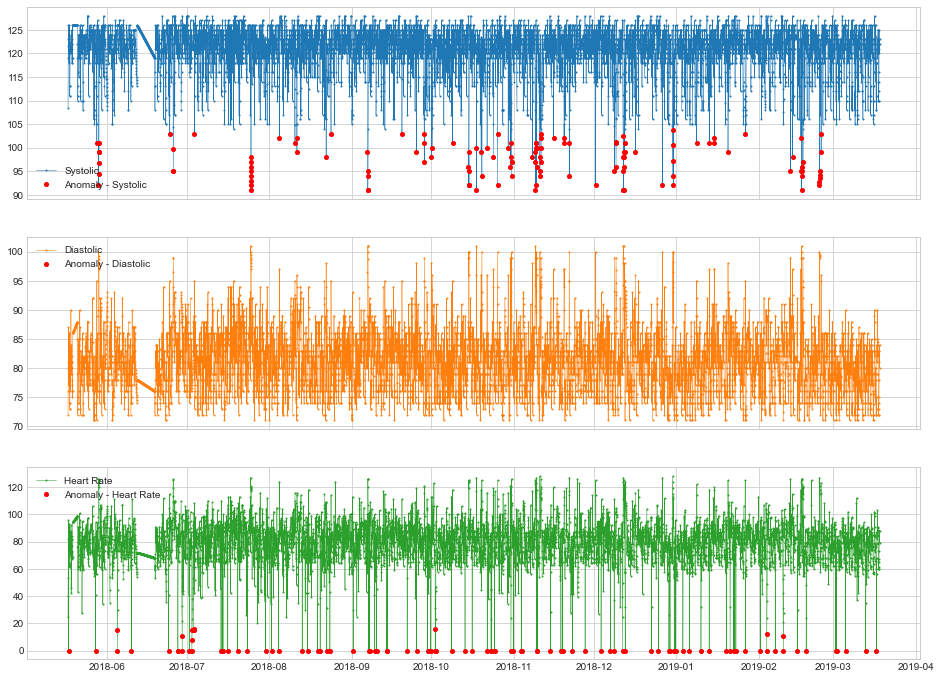

In [20]:
IQR_AD = InterQuartileRangeAD()
anomalies = IQR_AD.fit_detect(df_time_imputed)
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

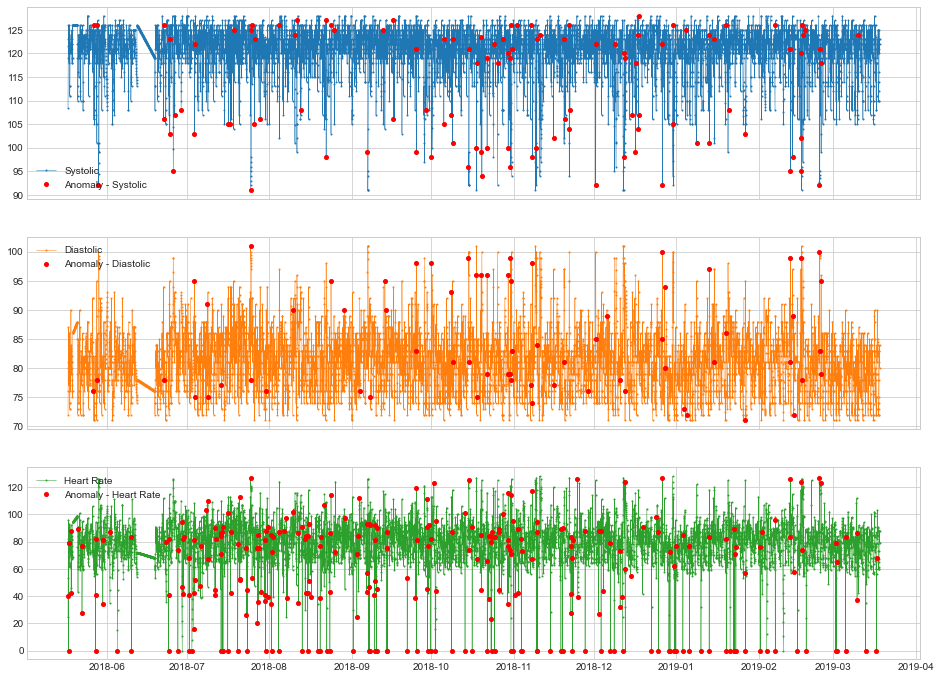

In [21]:
#compares time series values with the values of their preceding time windows, and identifies a time point as anomalous if the change of value from its preceding average or median is anomalously large
Persist_AD = PersistAD()
anomalies = Persist_AD.fit_detect(df_time_imputed)
#parameter = IQR_AD.get_params()
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

#must seperate since cannot set threshold manually

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

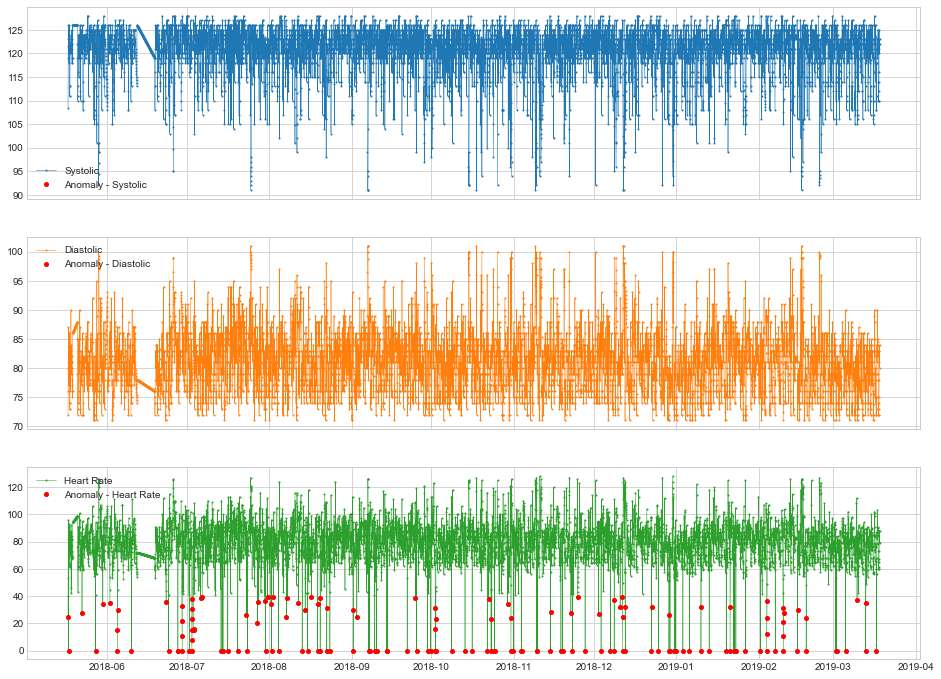

In [22]:
Threshold_AD = ThresholdAD(low=40, high=200)
anomalies = Threshold_AD.detect(df_time_imputed)
plot(df_time_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [23]:
#print_all_models()

Time series modelling

Vector Auto Regression (VAR)

In [24]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [25]:
df = df_time_imputed
test_size = 24

df_train = df[:-test_size]
df_test = df[-test_size:]


In [26]:
df_bp = df[['Systolic','Diastolic']]

Granger’s Causality Test
test this relationship 

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [28]:
grangers_causation_matrix(df, variables = df.columns)   

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints 

Systolic_x  Diastolic_x  Heart Rate_x
Systolic_y           1.0          0.0           0.0
Diastolic_y          0.0          1.0           0.0
Heart Rate_y         0.0          0.0           1.0

In [29]:
#df_bp

In [30]:
grangers_causation_matrix(df_bp, variables = df_bp.columns)   

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints 

Systolic_x  Diastolic_x
Systolic_y          1.0          0.0
Diastolic_y         0.0          1.0

In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Systolic ::  1498.78   > 24.2761   =>   True
Diastolic ::  614.85    > 12.3212   =>   True
Heart Rate ::  0.44      > 4.1296    =>   False


Spilt train test set

In [32]:
nobs = 24
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(7298, 3)
(24, 3)


Stationarity test

In [33]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [34]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Systolic" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8444
 No. Lags Chosen       = 32
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diastolic" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.0629
 No. Lags Chosen       = 36
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Heart Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

Since series is staionary can proceed to next step without differencing

In [35]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    

Lag Order = 1
AIC :  10.537335946699445
BIC :  10.5486434219782
FPE :  37697.00574323929
HQIC:  10.541223556495455 

Lag Order = 2
AIC :  10.518412054114902
BIC :  10.53820244724961
FPE :  36990.3392382293
HQIC:  10.525216212591495 

Lag Order = 3
AIC :  10.514922312685838
BIC :  10.543197605699643
FPE :  36861.477620337864
HQIC:  10.524643741295389 

Lag Order = 4
AIC :  10.513126255036763
BIC :  10.54988843069645
FPE :  36795.33192507398
HQIC:  10.52576567551018 

Lag Order = 5
AIC :  10.512280224345304
BIC :  10.557531266161682
FPE :  36764.21546631544
HQIC:  10.527838358692174 

Lag Order = 6
AIC :  10.512085972746094
BIC :  10.565827864974377
FPE :  36757.07517128272
HQIC:  10.530563543254836 

Lag Order = 7
AIC :  10.508387610770278
BIC :  10.570622338410466
FPE :  36621.38598150363
HQIC:  10.529785340008276 

Lag Order = 8
AIC :  10.508636920157384
BIC :  10.57936646895465
FPE :  36630.51810773774
HQIC:  10.532955530971147 

Lag Order = 9
AIC :  10.508037862238986
BIC :  10.5872

In [36]:
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

select lag 4 since it's the minimum

In [37]:
model_fitted = model.fit(4)
#model_fitted.summary()

In [38]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Systolic : 2.0
Diastolic : 2.0
Heart Rate : 2.0


The closer it is to the value 2, then there is no significant serial correlation

In [39]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

4


array([[123.,  81.,  80.],
       [121.,  83.,  88.],
       [122.,  84.,  88.],
       [123.,  80.,  79.]])

In [40]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast

Systolic  Diastolic  Heart Rate
Timestamp                                             
2019-03-17 12:00:00  121.697679  80.379336   78.544614
2019-03-17 13:00:00  121.099829  80.439794   77.975566
2019-03-17 14:00:00  120.839244  80.398511   77.928269
2019-03-17 15:00:00  120.628307  80.538358   78.015804
2019-03-17 16:00:00  120.520433  80.635926   78.154296
2019-03-17 17:00:00  120.465719  80.715427   78.317515
2019-03-17 18:00:00  120.430459  80.781988   78.449713
2019-03-17 19:00:00  120.408921  80.829708   78.547294
2019-03-17 20:00:00  120.394697  80.863765   78.619720
2019-03-17 21:00:00  120.384213  80.887525   78.670142
2019-03-17 22:00:00  120.376441  80.903659   78.704390
2019-03-17 23:00:00  120.370569  80.914532   78.727455
2019-03-18 00:00:00  120.366122  80.921799   78.742829
2019-03-18 01:00:00  120.362806  80.926642   78.753069
2019-03-18 02:00:00  120.360364  80.929874   78.759906
2019-03-18 03:00:00  120.358593  80.932036   78.764494
2019-03-18 04:00:00  120.357327  80.933491   78.767596
2019-03-18 05:00:00  120.356432  80.934474   78.769709
2019-03-18 06:00:00  120.355807  80.935142   78.771157
2019-03-18 07:00:00  120.355374  80.935599   78.772156
2019-03-18 08:00:00  120.355076  80.935912   78.772847
2019-03-18 09:00:00  120.354871  80.936127   78.773326
2019-03-18 10:00:00  120.354731  80.936275   78.773658
2019-03-18 11:00:00  120.354636  80.936378   78.773888

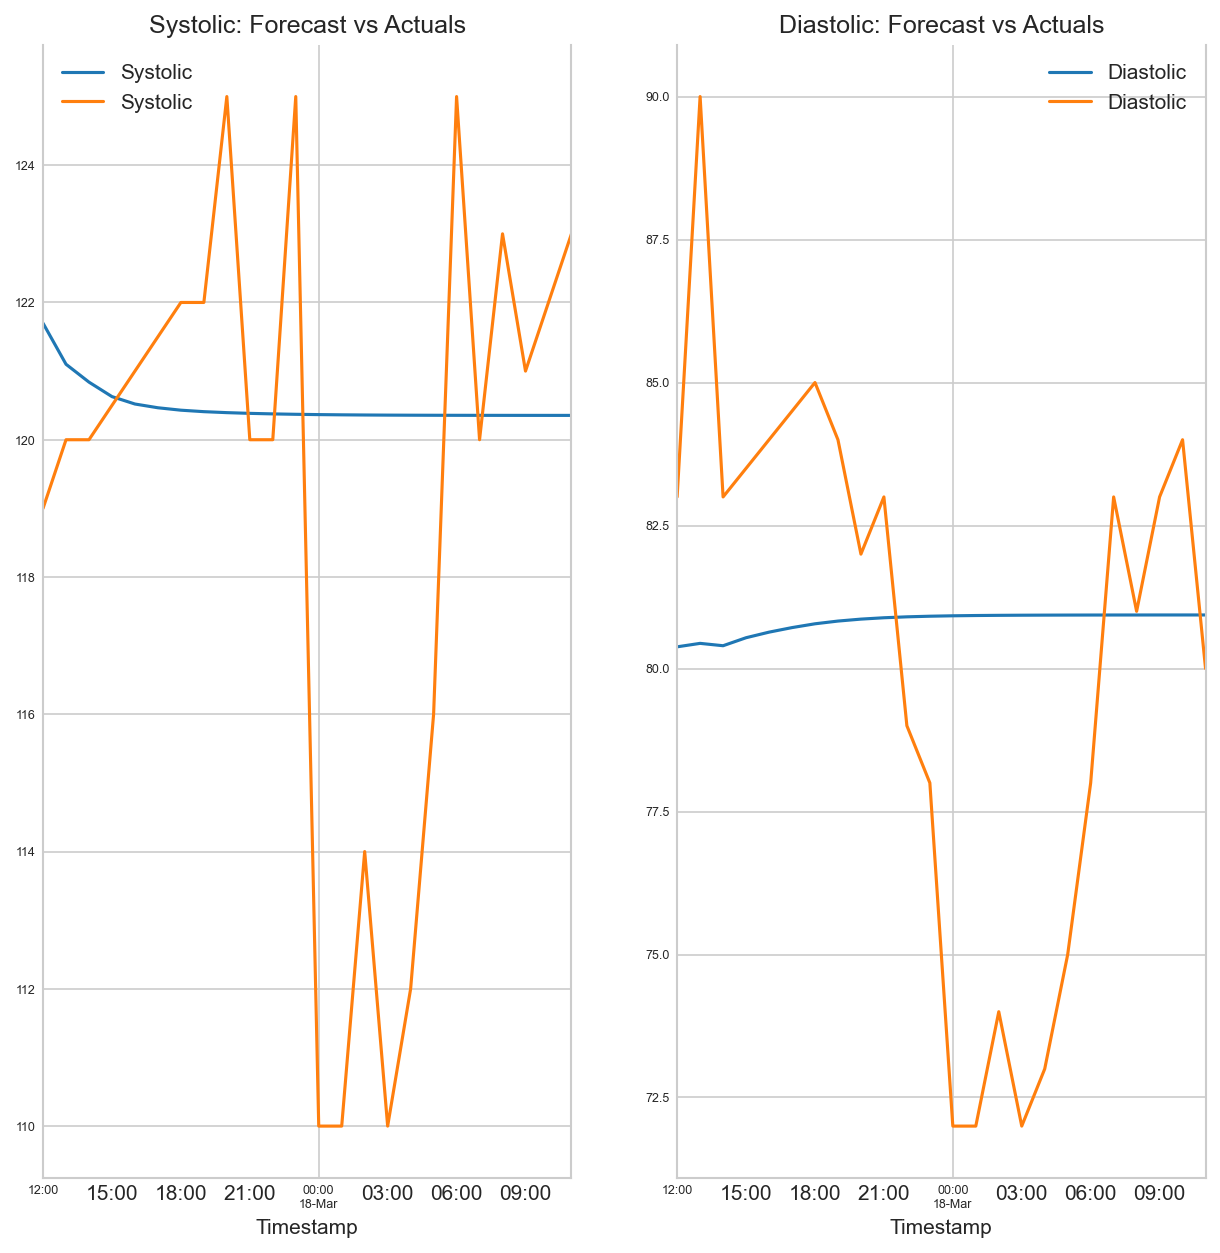

In [41]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [42]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


In [43]:
print('Forecast Accuracy of: systolic')
accuracy_prod = forecast_accuracy(df_forecast['Systolic'].values, df_test['Systolic'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('\n Forecast Accuracy of: Diastolic')
accuracy_prod = forecast_accuracy(df_forecast['Diastolic'].values, df_test['Diastolic'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('\n Forecast Accuracy of: Heart Rate')
accuracy_prod = forecast_accuracy(df_forecast['Heart Rate'].values, df_test['Heart Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: systolic
mape :  0.0296
me :  1.2462
mae :  3.424
mpe :  0.012
rmse :  4.7813
corr :  0.0567
minmax :  0.0282

 Forecast Accuracy of: Diastolic
mape :  0.0528
me :  0.5618
mae :  4.1272
mpe :  0.0109
rmse :  4.9909
corr :  -0.5687
minmax :  0.0499

 Forecast Accuracy of: Heart Rate
mape :  0.1364
me :  -0.9438
mae :  10.2572
mpe :  0.0122
rmse :  11.9165
corr :  -0.6004
minmax :  0.1212


SARIMAX model

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tqdm import tqdm_notebook

%matplotlib inline


Plot acf and pacf of  original 

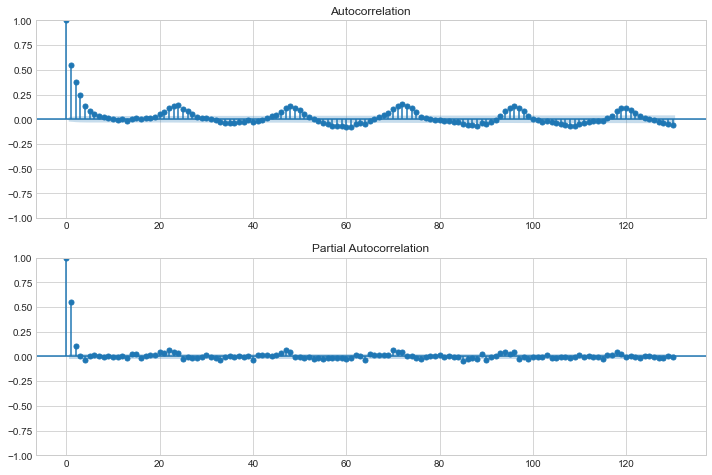

In [105]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.Systolic, lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.Systolic, lags=130, ax=ax2)

shows that the ACF plot decays and dies down in a damp sine-wave fashion while the PACF plot cuts off after the second lag, may have seasonality 

In [ ]:
df_train['seasonal_difference'] = df_train.Systolic-df_train.Systolic.shift(24)

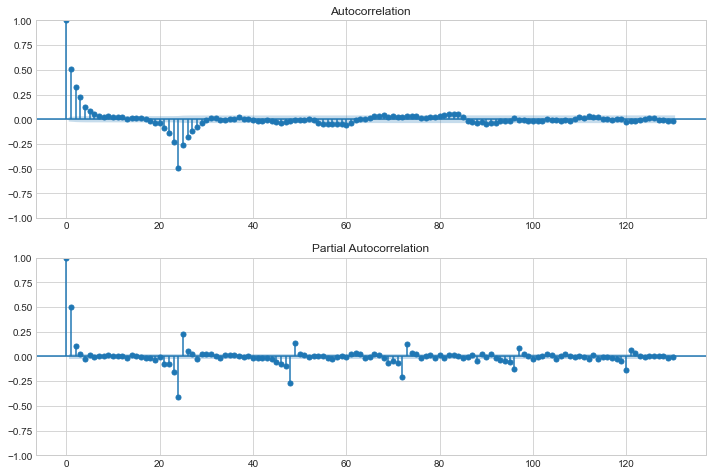

In [96]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_train.seasonal_difference.iloc[25:], lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_train.seasonal_difference.iloc[25:], lags=130, ax=ax2)

In [ ]:
df_train['seasonal_difference_2'] = df_train.seasonal_difference-df.seasonal_difference.shift(24)

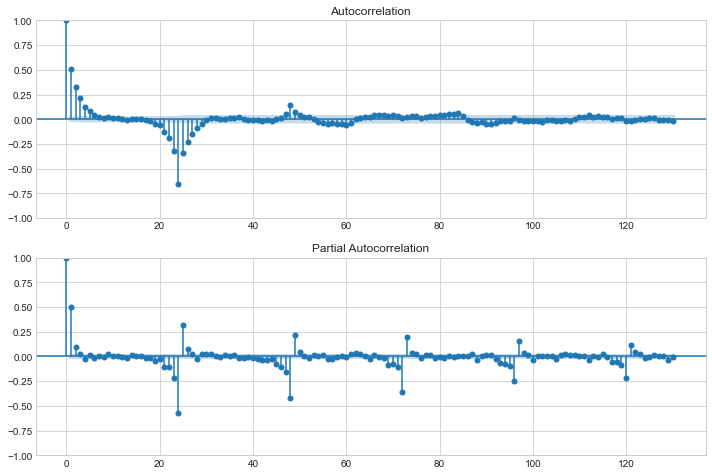

In [98]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_train.seasonal_difference_2.iloc[49:], lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_train.seasonal_difference_2.iloc[49:], lags=130, ax=ax2)

seasonality test

In [48]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [49]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [50]:
acorr_ljungbox(df.Systolic, lags=[24], return_df=True)


lb_stat  lb_pvalue
24  4402.031352        0.0

In [ ]:
no seasonality 

In [51]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

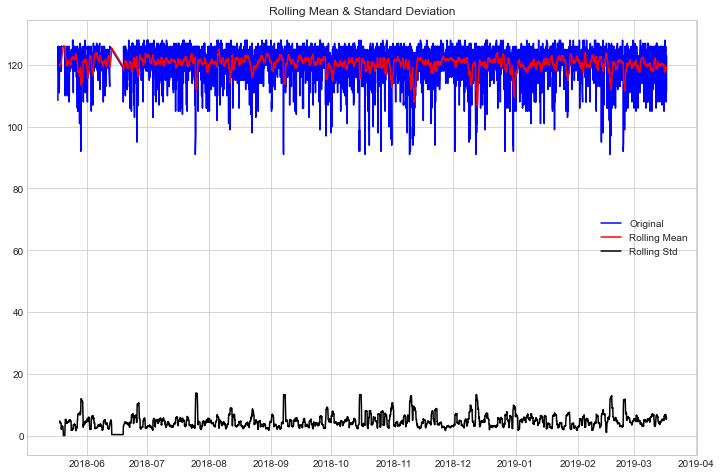

Results of Dickey-Fuller Test:
Test Statistic                -1.284437e+01
p-value                        5.520400e-24
#Lags Used                     3.200000e+01
Number of Observations Used    7.265000e+03
Critical Value (1%)           -3.431250e+00
Critical Value (5%)           -2.861938e+00
Critical Value (10%)          -2.566982e+00
dtype: float64


In [89]:
test_stationarity(df_train.Systolic)

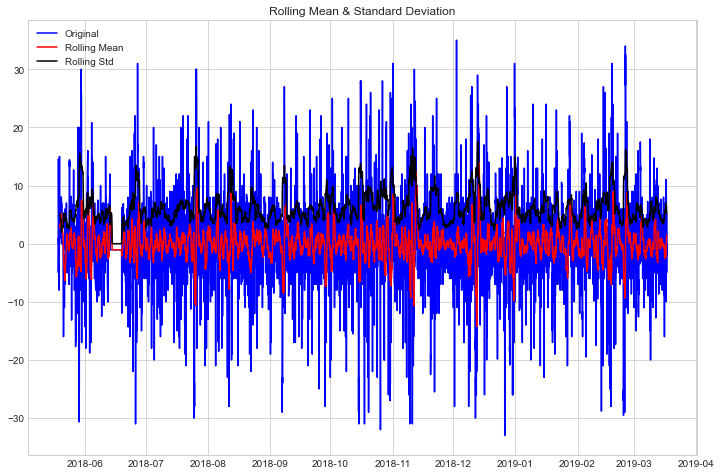

Results of Dickey-Fuller Test:
Test Statistic                -1.861533e+01
p-value                        2.063455e-30
#Lags Used                     3.000000e+01
Number of Observations Used    7.243000e+03
Critical Value (1%)           -3.431253e+00
Critical Value (5%)           -2.861939e+00
Critical Value (10%)          -2.566982e+00
dtype: float64


In [91]:
test_stationarity(df.seasonal_difference.dropna(inplace=False))

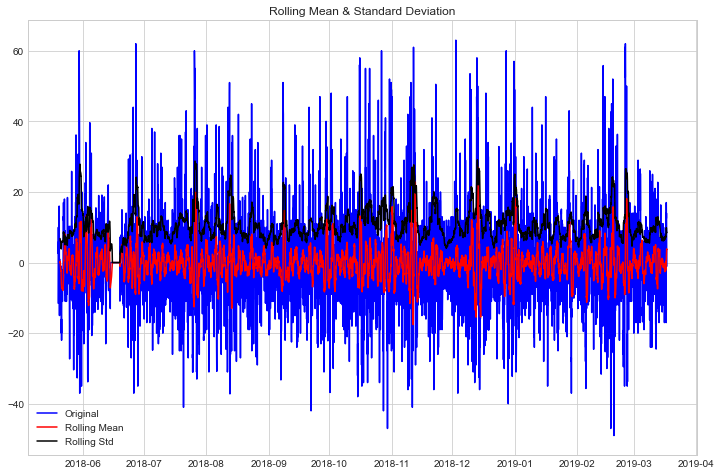

Results of Dickey-Fuller Test:
Test Statistic                  -20.577862
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    7219.000000
Critical Value (1%)              -3.431256
Critical Value (5%)              -2.861940
Critical Value (10%)             -2.566983
dtype: float64


In [97]:
test_stationarity(df_train.seasonal_difference_2.dropna(inplace=False))

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

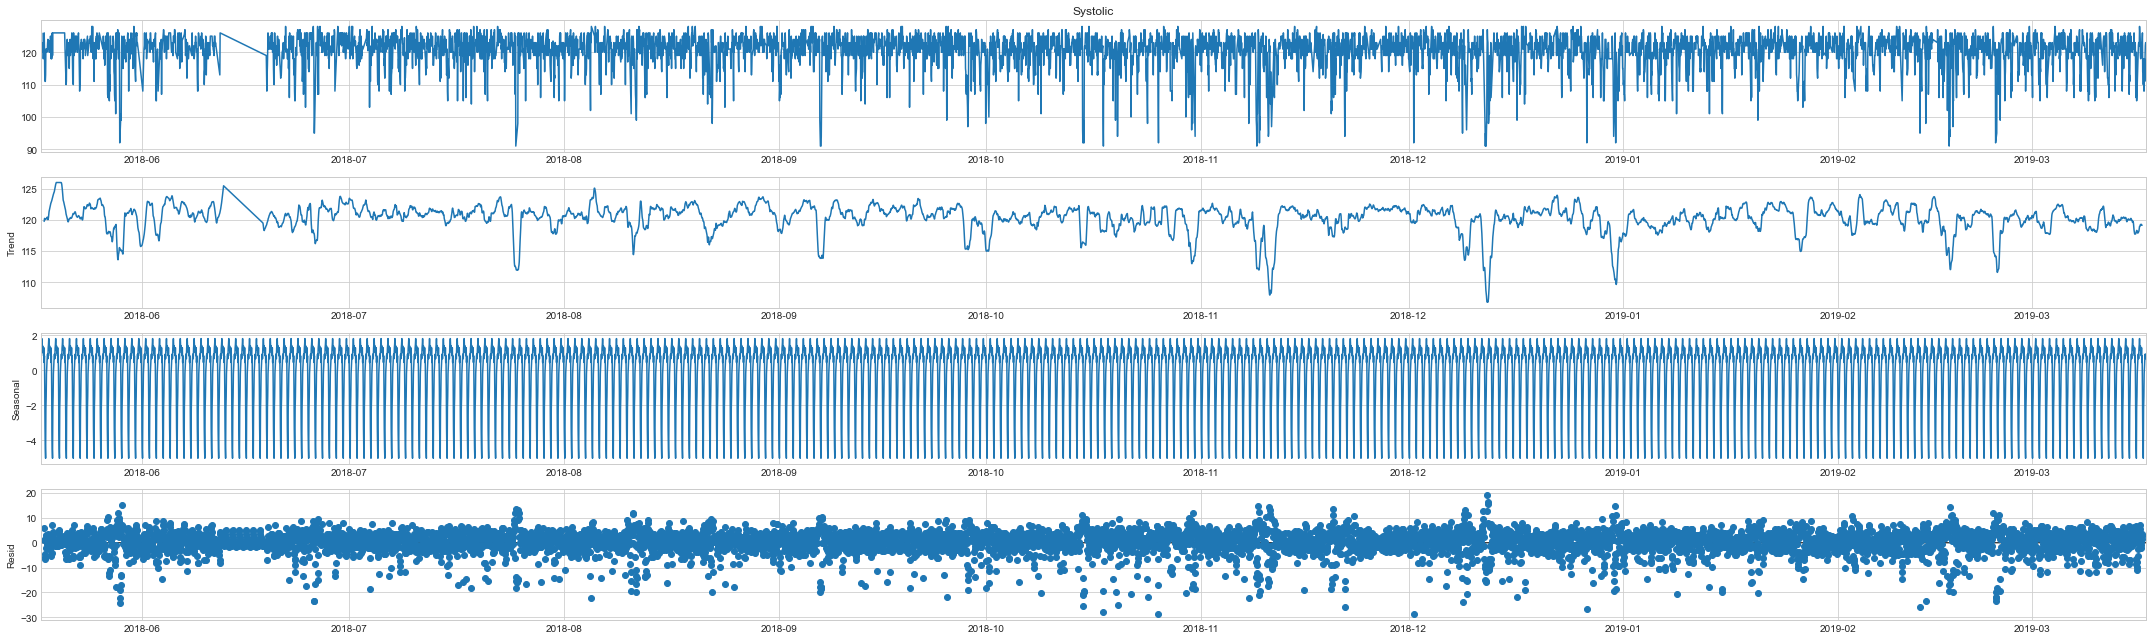

In [93]:
plt.rcParams["figure.figsize"] = [30,9]
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df_train.Systolic,period=24)
result.plot()
pyplot.show()

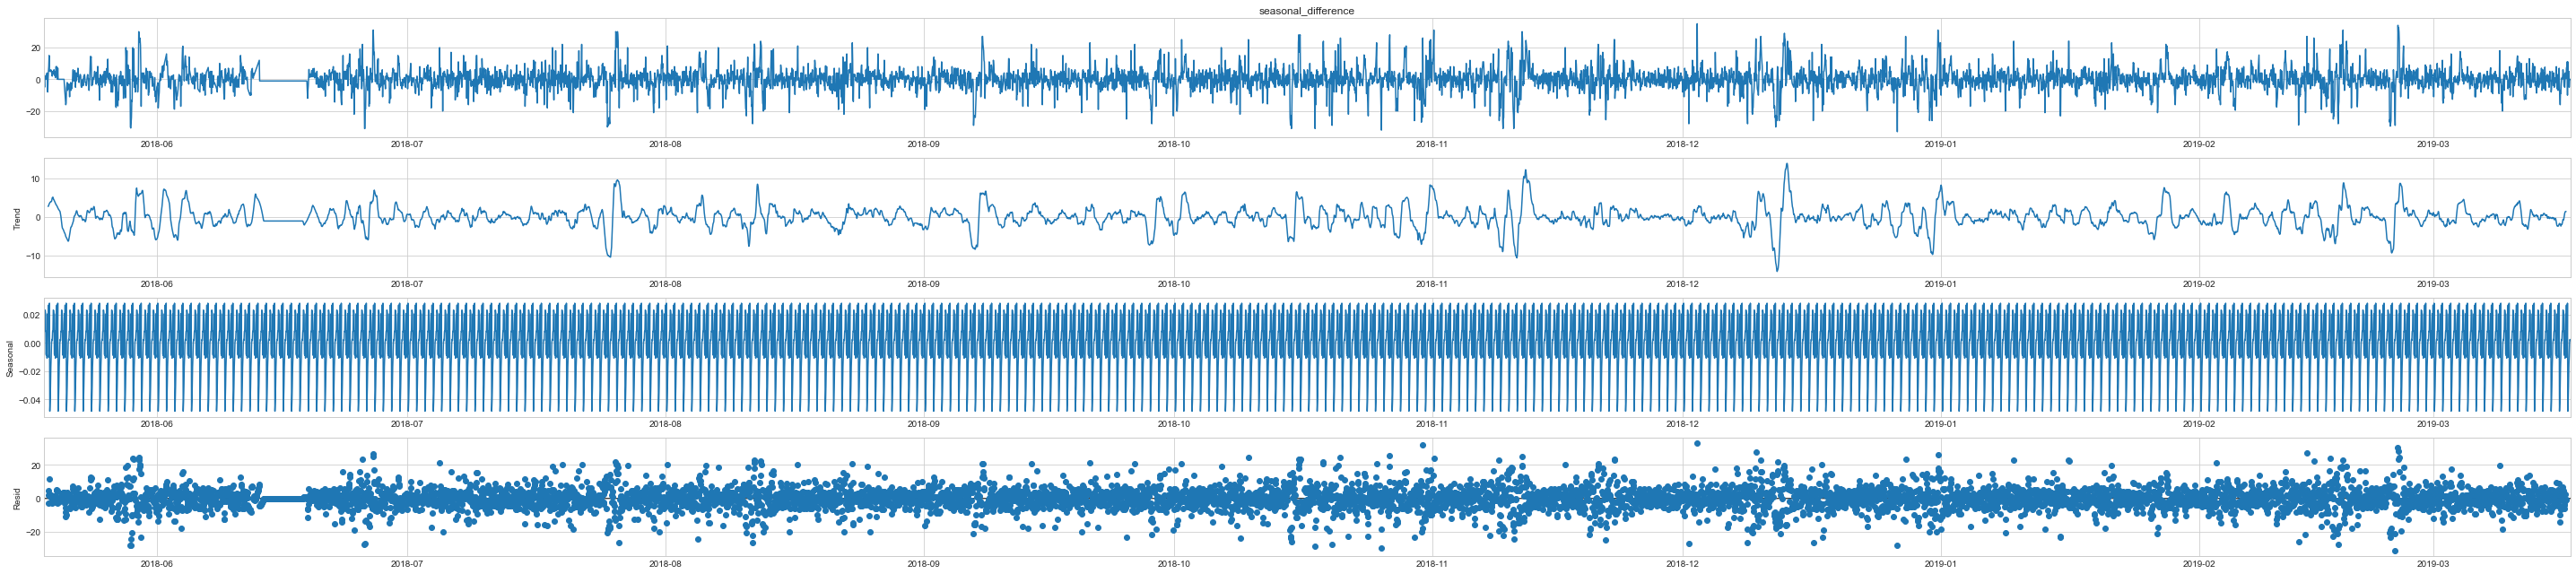

In [95]:
plt.rcParams["figure.figsize"] = [40,9]
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df_train.seasonal_difference.iloc[25:],period=24)
result.plot()
pyplot.show()

In [104]:
import statsmodels.api as sm
mod =  sm.tsa.arima.ARIMA(df_train.seasonal_difference.dropna(), order=(1,0,0))
results = mod.fit()
print (results.summary())

                                SARIMAX Results                                
Dep. Variable:     seasonal_difference   No. Observations:                 7274
Model:                  ARIMA(1, 0, 0)   Log Likelihood              -23531.769
Date:                 Wed, 17 Aug 2022   AIC                          47069.537
Time:                         22:18:15   BIC                          47090.214
Sample:                     05-18-2018   HQIC                         47076.648
                          - 03-17-2019                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.145     -0.004      0.997      -0.286       0.284
ar.L1          0.5043      0.007     75.508      0.000       0.491       0.517
sigma2        37.7957      0.399     94.828 

In [62]:
#!pip install pmdarima


In [63]:
from pmdarima.arima import auto_arima

In [64]:
model = auto_arima(df_train.Systolic, start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7298
Model:               SARIMAX(0, 1, 3)   Log Likelihood              -21521.449
Date:                Wed, 17 Aug 2022   AIC                          43050.898
Time:                        20:53:27   BIC                          43078.479
Sample:                             0   HQIC                         43060.382
                               - 7298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5267      0.007    -73.184      0.000      -0.541      -0.513
ma.L2         -0.2032      0.010    -19.979      0.000      -0.223      -0.183
ma.L3         -0.2261      0.009    -24.123      0.000      -0.245      -0.208
sigma2        21.3387      0.199    106.988      0.000      20.948      21.730
===================================================================================
Ljung-Box (L1) (Q):                  12.32   Jarque-Bera (JB):              7425.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

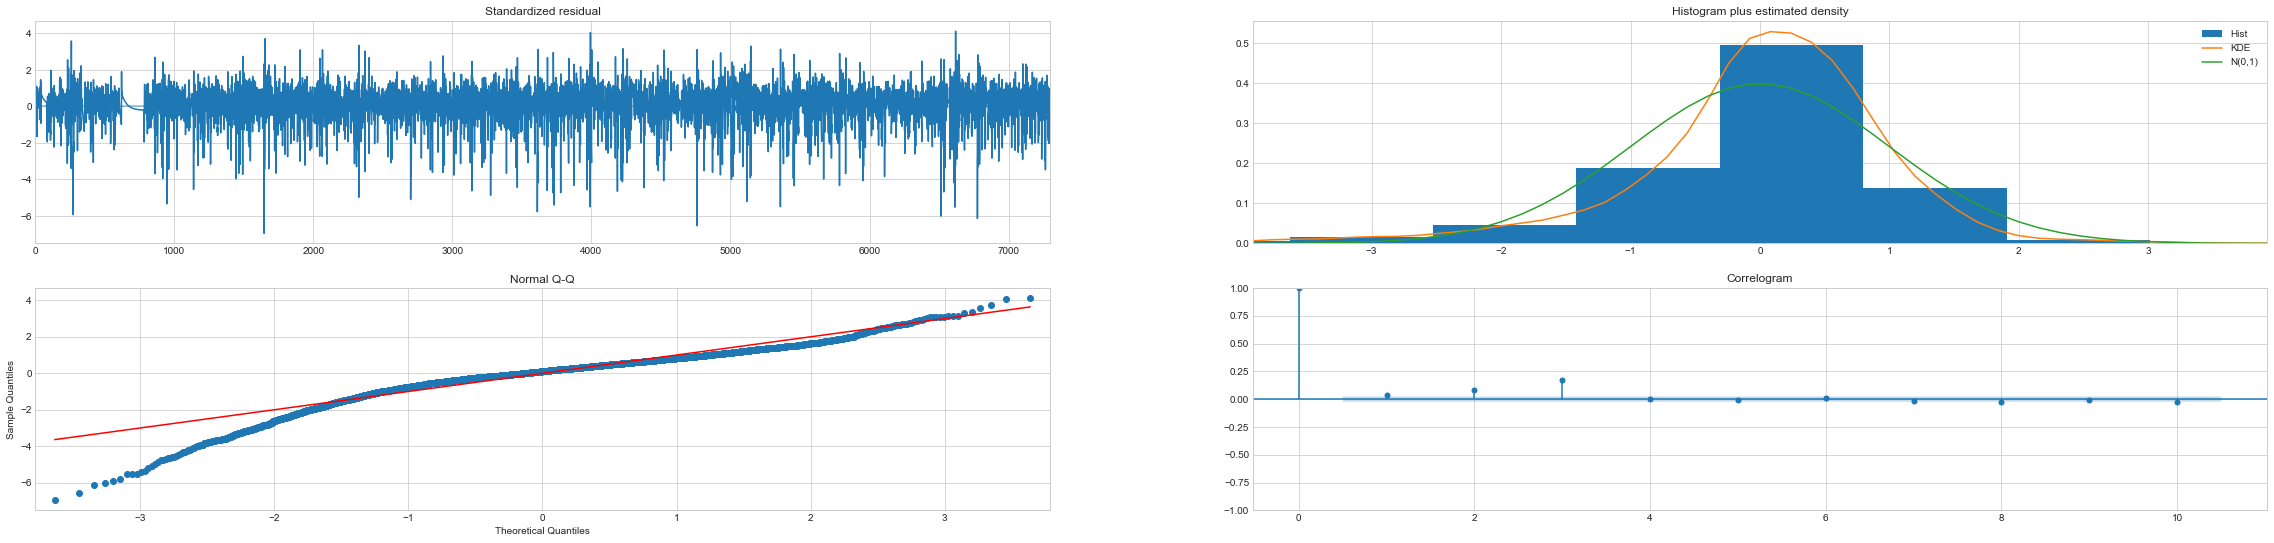

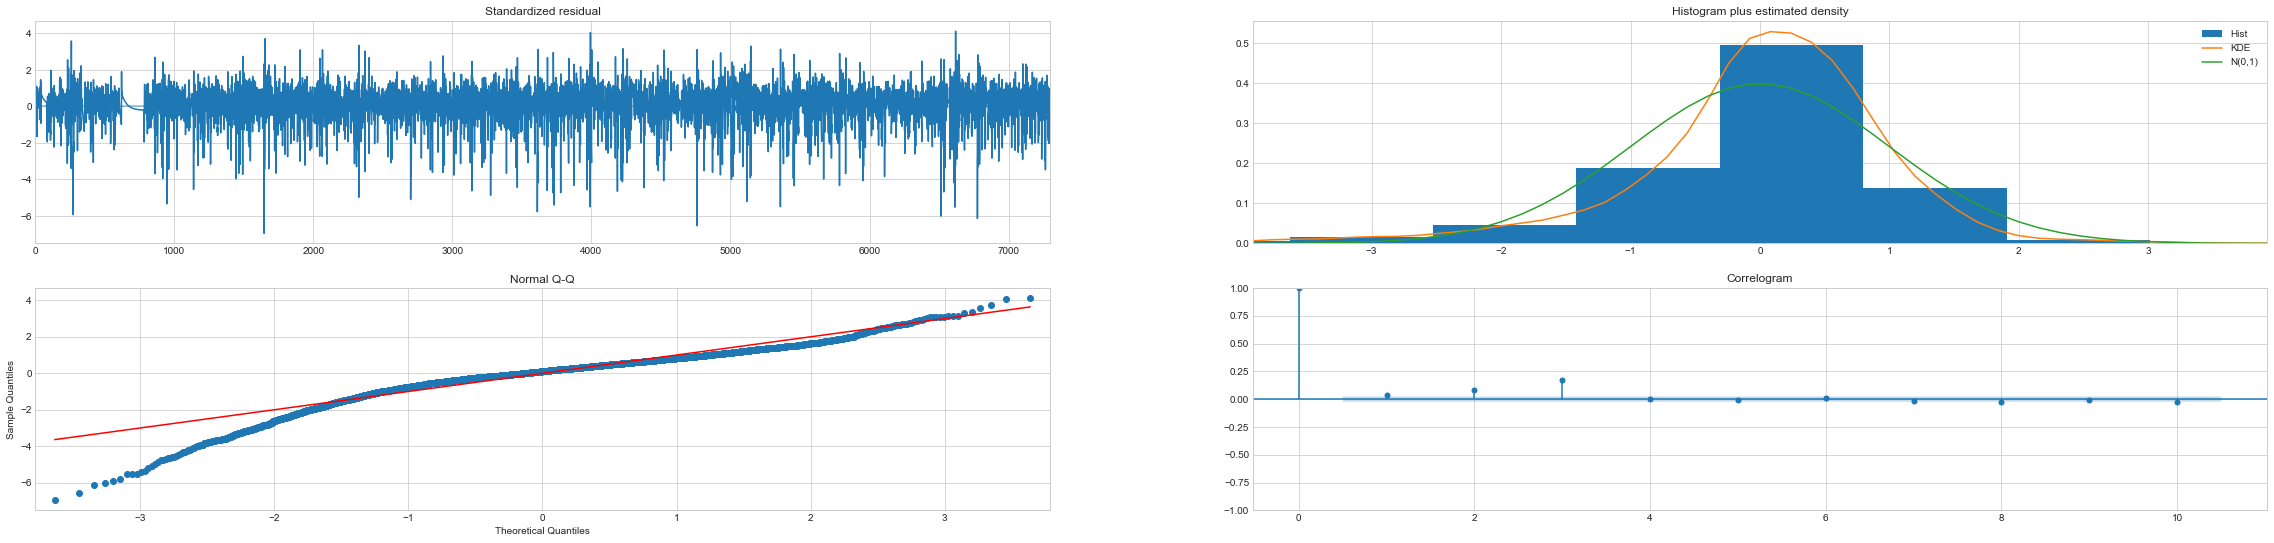

In [65]:
model.plot_diagnostics()


In [67]:
prediction =pd.DataFrame(model.predict(n_periods=24, return_conf_int=True))
prediction


0   \
0                                120.592539   
1  [111.53871641091615, 129.64636126369692]   

                                         1   \
0                                119.186076   
1  [109.16922937741158, 129.20292282140534]   

                                         2   \
0                                118.746569   
1  [108.43556212964376, 129.05757565193025]   

                                       3   \
0                              118.746569   
1  [108.4278832254193, 129.0652545561547]   

                                         4   \
0                                118.746569   
1  [108.42021003139284, 129.07292775018115]   

                                         5   \
0                                118.746569   
1  [108.41254253484463, 129.08059524672936]   

                                         6   \
0                                118.746569   
1  [108.40488072310207, 129.08825705847195]   

                                        7   \
0                               118.746569   
1  [108.39722458353941, 129.0959131980346]   

                                         8   \
0                                118.746569   
1  [108.38957410357767, 129.10356367799633]   

                                         9   ...  \
0                                118.746569  ...   
1  [108.38192927068421, 129.11120851088978]  ...   

                                         14  \
0                                118.746569   
1  [108.34378937681956, 129.14934840475445]   

                                         15  \
0                                118.746569   
1  [108.33617816572082, 129.15695961585317]   

                                         16  \
0                                118.746569   
1  [108.32857251524207, 129.16456526633192]   

                                         17  \
0                                118.746569   
1  [108.32097241321362, 129.17216536836037]   

                                         18  \
0                                118.746569   
1  [108.31337784751008, 129.17975993406392]   

                                         19  \
0                                118.746569   
1  [108.30578880605019, 129.18734897552383]   

                                         20  \
0                                118.746569   
1  [108.29820527679652, 129.19493250477748]   

                                         21  \
0                                118.746569   
1  [108.29062724775535, 129.20251053381867]   

                                         22  \
0                                118.746569   
1  [108.28305470697636, 129.21008307459766]   

                                        23  
0                               118.746569  
1  [108.27548764255242, 129.2176501390216]  

[2 rows x 24 columns]

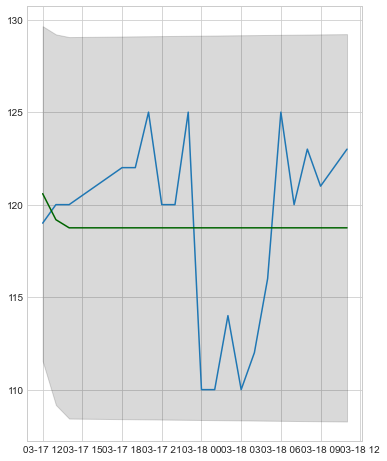

In [68]:
# Forecast
plt.figure(figsize=(6,8))
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_test.Systolic)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("")
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
   
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, df_test.Systolic)

In [69]:
model = auto_arima(df_train.Diastolic, start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7298
Model:               SARIMAX(0, 1, 4)   Log Likelihood              -20068.465
Date:                Wed, 17 Aug 2022   AIC                          40146.931
Time:                        20:54:47   BIC                          40181.407
Sample:                             0   HQIC                         40158.786
                               - 7298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3445      0.009    -38.806      0.000      -0.362      -0.327
ma.L2         -0.2280      0.011    -21.628      0.000      -0.249      -0.207
ma.L3         -0.1852      0.011    -16.835      0.000      -0.207      -0.164
ma.L4         -0.2135      0.011    -20.135      0.000      -0.234      -0.193
sigma2        14.3281      0.173     82.639      0.000      13.988      14.668
===================================================================================
Ljung-Box (L1) (Q):                   8.25   Jarque-Bera (JB):              1611.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.48
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

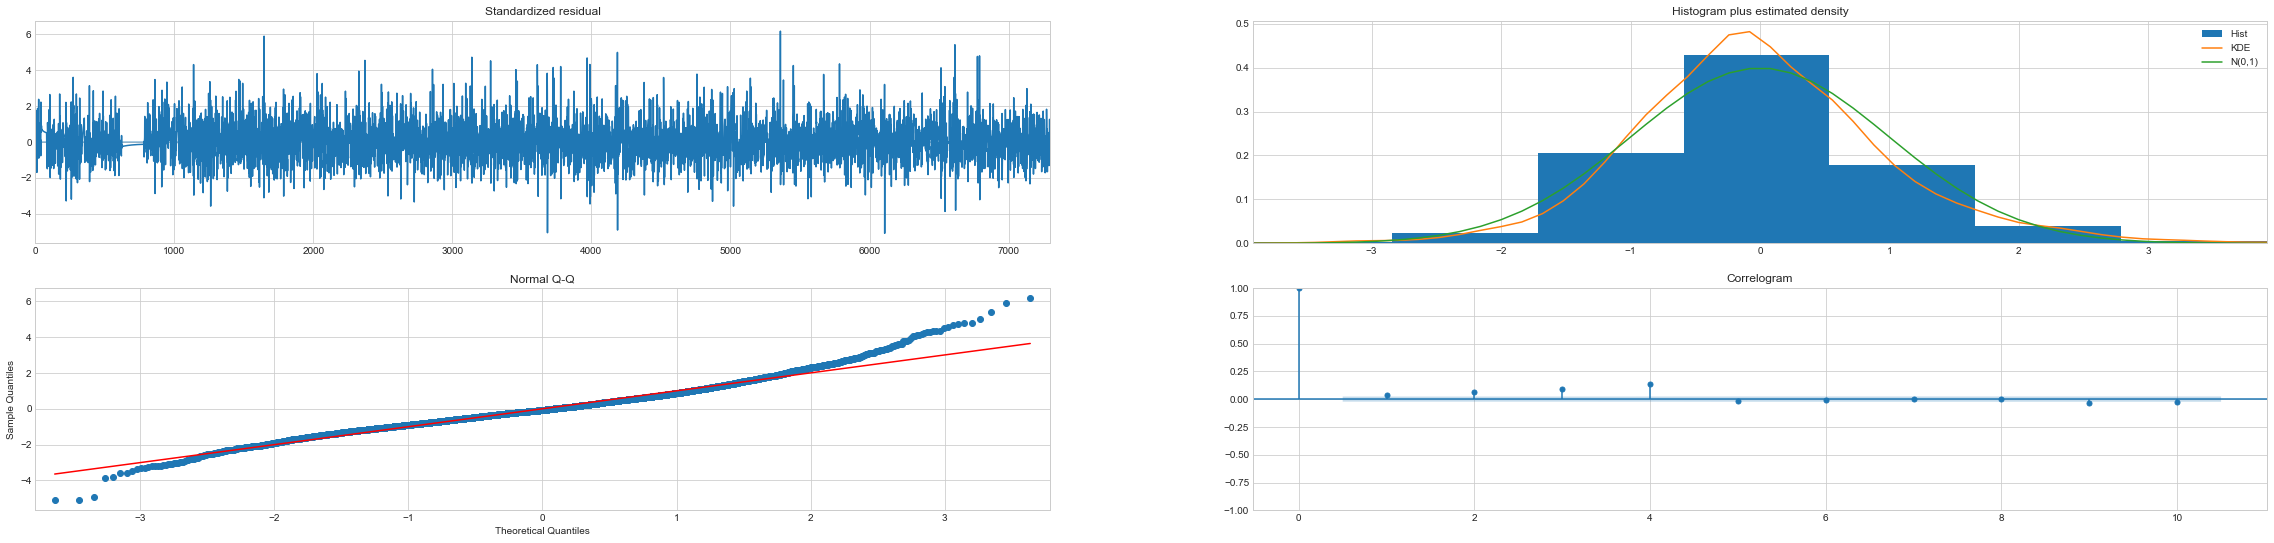

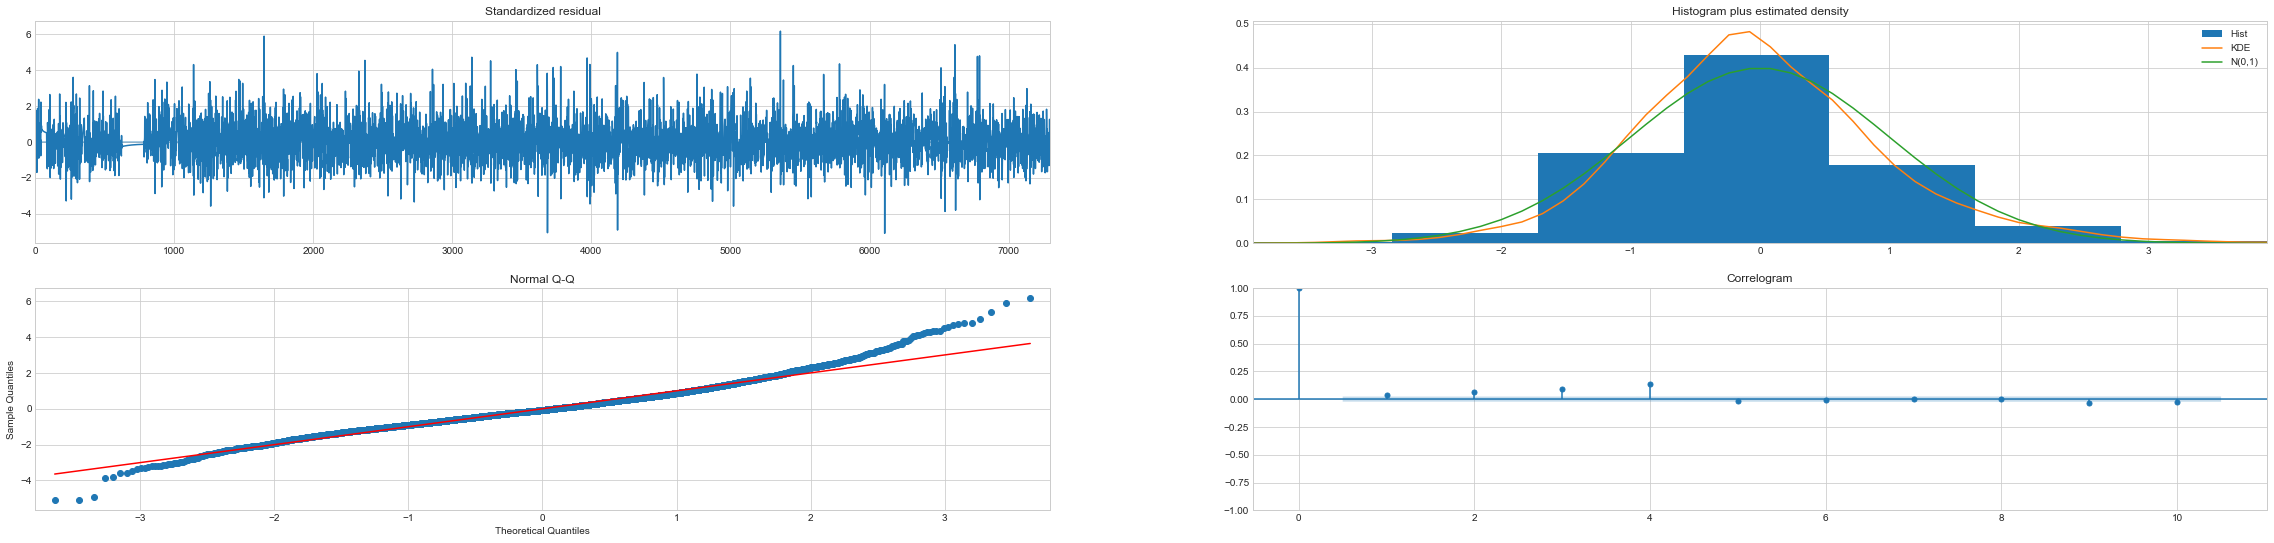

In [70]:
model.plot_diagnostics()


In [67]:
prediction =pd.DataFrame(model.predict(n_periods=24, return_conf_int=True))
prediction


0   \
0                                120.592539   
1  [111.53871641091615, 129.64636126369692]   

                                         1   \
0                                119.186076   
1  [109.16922937741158, 129.20292282140534]   

                                         2   \
0                                118.746569   
1  [108.43556212964376, 129.05757565193025]   

                                       3   \
0                              118.746569   
1  [108.4278832254193, 129.0652545561547]   

                                         4   \
0                                118.746569   
1  [108.42021003139284, 129.07292775018115]   

                                         5   \
0                                118.746569   
1  [108.41254253484463, 129.08059524672936]   

                                         6   \
0                                118.746569   
1  [108.40488072310207, 129.08825705847195]   

                                        7   \
0                               118.746569   
1  [108.39722458353941, 129.0959131980346]   

                                         8   \
0                                118.746569   
1  [108.38957410357767, 129.10356367799633]   

                                         9   ...  \
0                                118.746569  ...   
1  [108.38192927068421, 129.11120851088978]  ...   

                                         14  \
0                                118.746569   
1  [108.34378937681956, 129.14934840475445]   

                                         15  \
0                                118.746569   
1  [108.33617816572082, 129.15695961585317]   

                                         16  \
0                                118.746569   
1  [108.32857251524207, 129.16456526633192]   

                                         17  \
0                                118.746569   
1  [108.32097241321362, 129.17216536836037]   

                                         18  \
0                                118.746569   
1  [108.31337784751008, 129.17975993406392]   

                                         19  \
0                                118.746569   
1  [108.30578880605019, 129.18734897552383]   

                                         20  \
0                                118.746569   
1  [108.29820527679652, 129.19493250477748]   

                                         21  \
0                                118.746569   
1  [108.29062724775535, 129.20251053381867]   

                                         22  \
0                                118.746569   
1  [108.28305470697636, 129.21008307459766]   

                                        23  
0                               118.746569  
1  [108.27548764255242, 129.2176501390216]  

[2 rows x 24 columns]

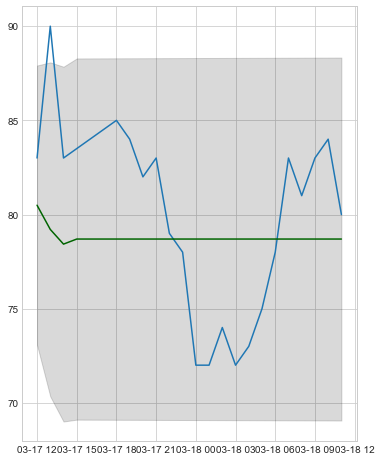

In [71]:
# Forecast
plt.figure(figsize=(6,8))
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_test.Diastolic)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("")
plt.show()

In [72]:


forecast_accuracy(fc, df_test.Diastolic)

{'mape': 0.055292153615454365,
 'me': -1.4677787447131656,
 'mae': 4.432678027705884,
 'mpe': -0.014645612253190263,
 'rmse': 5.0071991635140805,
 'corr': 0.20992421210587606,
 'minmax': 0.05380623465907719}

In [76]:
model = auto_arima(df_train['Heart Rate'], start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7298
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -29780.830
Date:                Wed, 17 Aug 2022   AIC                          59571.659
Time:                        20:56:00   BIC                          59606.136
Sample:                             0   HQIC                         59583.515
                               - 7298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.6810      0.882     40.477      0.000      33.953      37.409
ar.L1          0.4273      0.007     60.699      0.000       0.414       0.441
ar.L2          0.0906      0.010      8.715      0.000       0.070       0.111
ar.L3          0.0290      0.011      2.633      0.008       0.007       0.051
sigma2       204.8205      1.622    126.266      0.000     201.641     208.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42962.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.82
Prob(H) (two-sided):                  0.08   Kurtosis:                        14.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

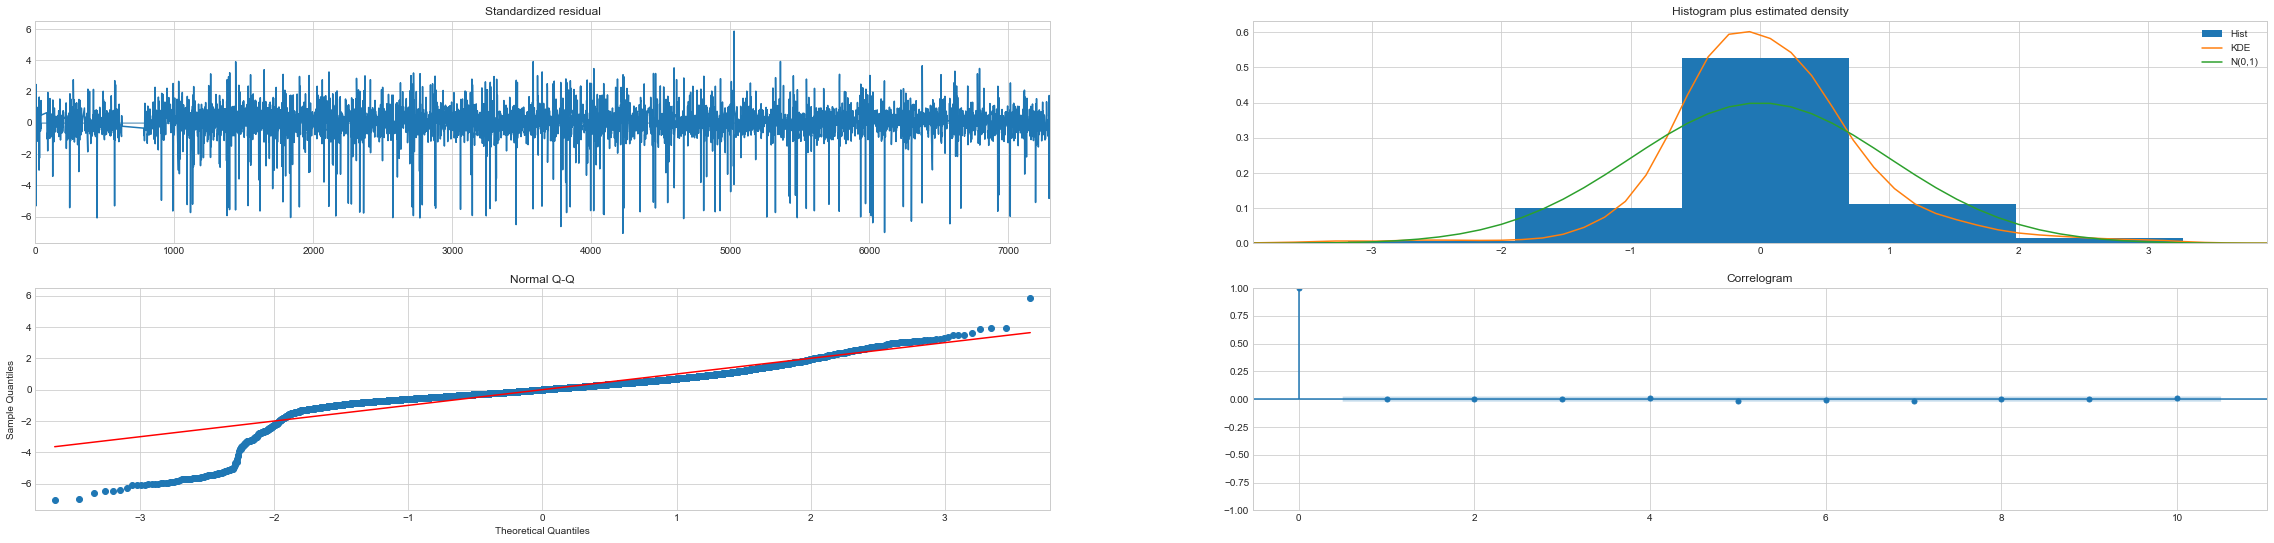

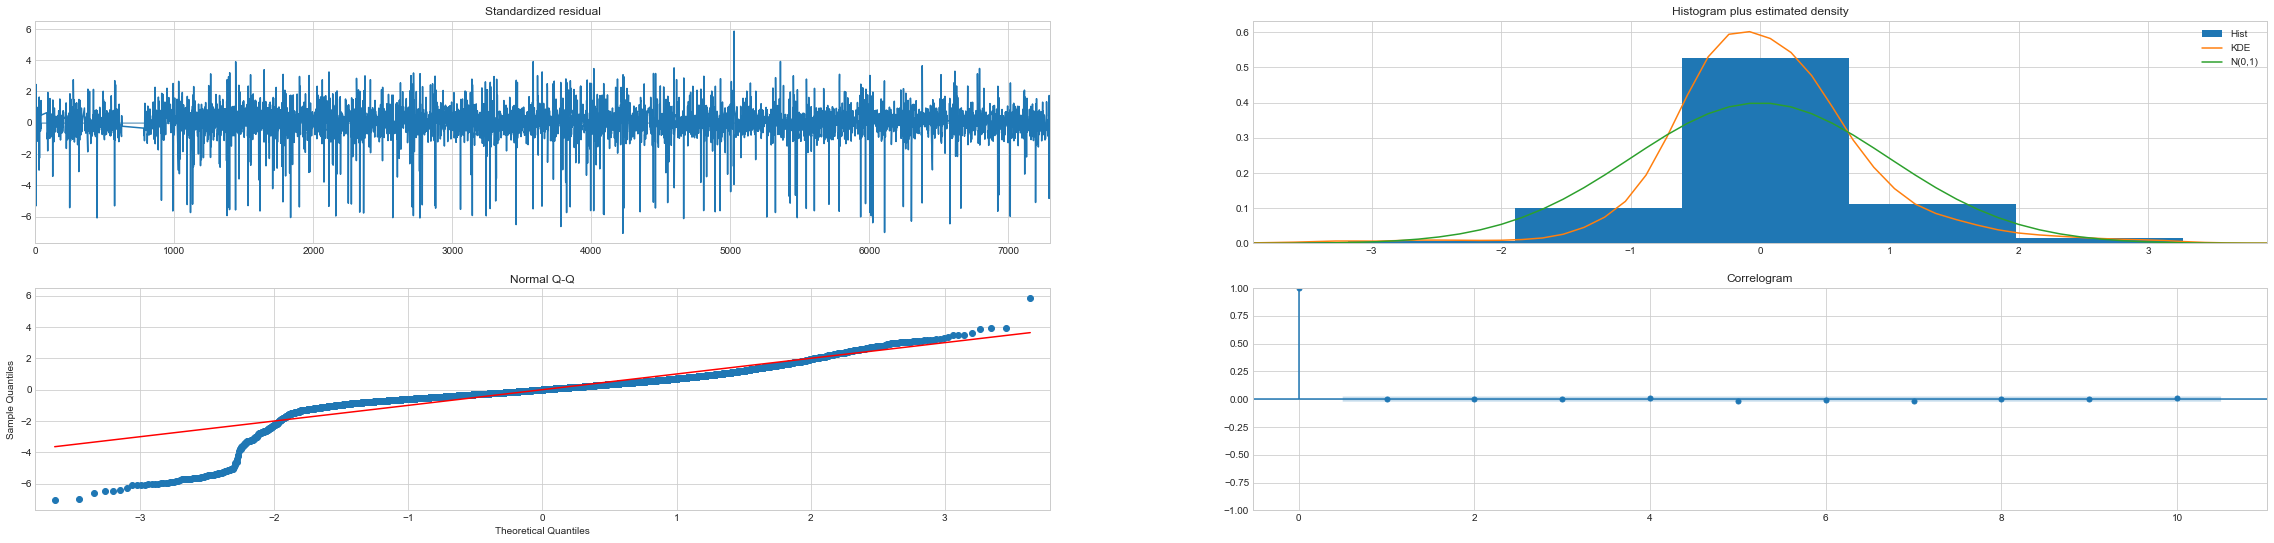

In [77]:
model.plot_diagnostics()


In [78]:
prediction =pd.DataFrame(model.predict(n_periods=24, return_conf_int=True))
prediction


0   \
0                                80.899577   
1  [52.84945438325323, 108.94969975759415]   

                                        1   \
0                                80.208572   
1  [49.70451549242683, 110.71262796180298]   

                                        2   \
0                                79.668394   
1  [48.21628107840893, 111.12050592965323]   

                                        3   \
0                                79.342992   
1  [47.46786835905313, 111.21811539409923]   

                                        4   \
0                                79.134927   
1  [47.09411309283701, 111.17574058023442]   

                                        5   \
0                                79.000844   
1  [46.89244695169944, 111.10924128181293]   

                                       6   \
0                               78.915245   
1  [46.77910901264872, 111.0513804496664]   

                                         7   \
0                                 78.860475   
1  [46.713003579636506, 111.00794542685475]   

                                        8   \
0                                 78.82542   
1  [46.67330923008442, 110.97753052953036]   

                                        9   ...  \
0                                78.802992  ...   
1  [46.64898126668429, 110.95700196689093]  ...   

                                         14  \
0                                 78.767417   
1  [46.612104851734436, 110.92272898008196]   

                                        15  \
0                                78.765878   
1  [46.61055662107957, 110.92119864339254]   

                                         16  \
0                                 78.764893   
1  [46.609568027828615, 110.92021737636254]   

                                         17  \
0                                 78.764262   
1  [46.608936308036185, 110.91958865610218]   

                                         18  \
0                                 78.763859   
1  [46.608532439735875, 110.91918601588293]   

                                        19  \
0                                78.763601   
1  [46.60827416099016, 110.91892823994334]   

                                         20  \
0                                 78.763436   
1  [46.608108955998176, 110.91876324081235]   

                                        21  \
0                                 78.76333   
1  [46.60800327121198, 110.91865764031064]   

                                         22  \
0                                 78.763263   
1  [46.607935657174906, 110.91859006078168]   

                                        23  
0                                 78.76322  
1  [46.60789239745342, 110.91854681518865]  

[2 rows x 24 columns]

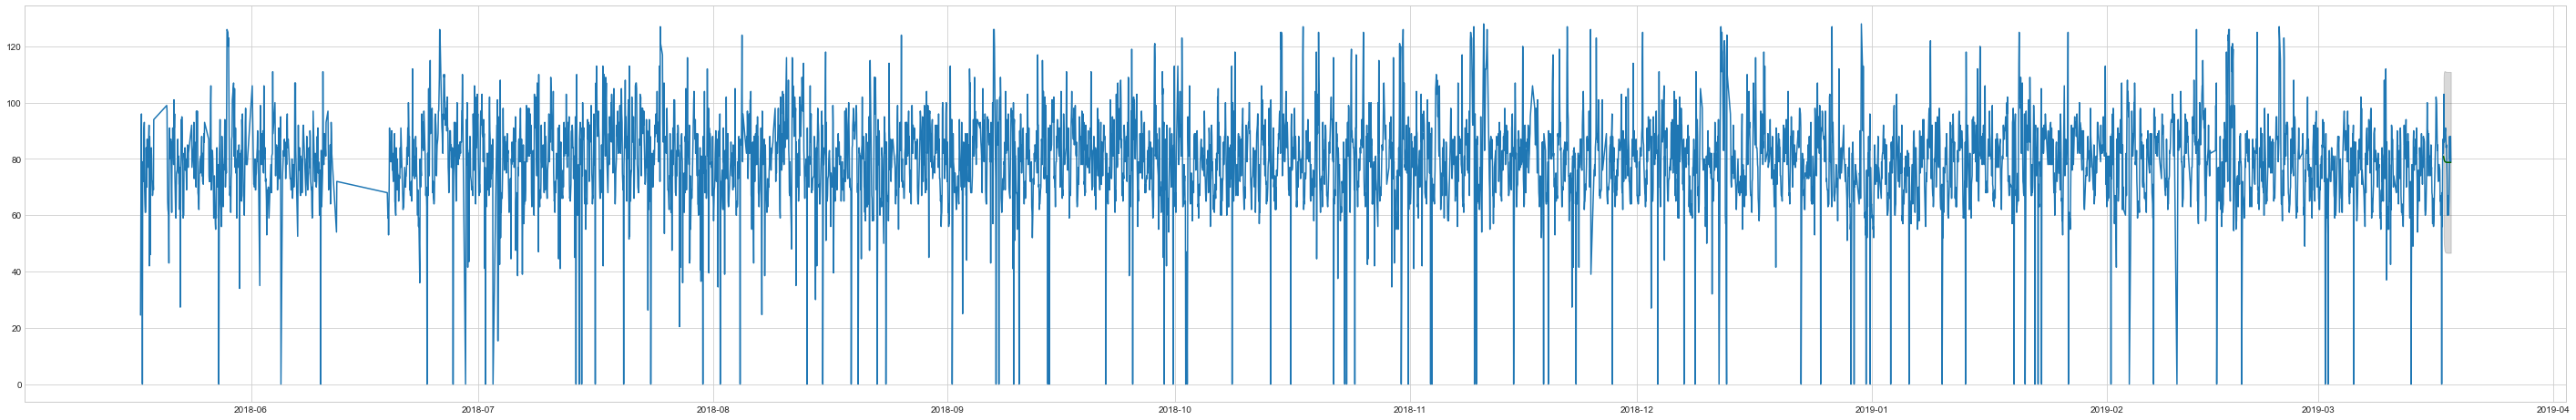

In [82]:
# Forecast
plt.figure(figsize=(50,8))
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df['Heart Rate'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("")
plt.show()

In [80]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
   
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, df_test['Heart Rate'])

{'mape': 0.13167785717695712,
 'me': -0.5035792375460174,
 'mae': 9.831730255589934,
 'mpe': 0.01710090702699504,
 'rmse': 11.495071213677708,
 'corr': 0.4537301032209211,
 'minmax': 0.1165009990507716}